In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
import glob
import imageio
import PIL
from IPython import display
import time
import random

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/weaponandnorm/train/train',
    image_size=(256, 256), 
    batch_size=32
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/weaponandnorm/test/test',
    image_size=(256, 256), 
    batch_size=32
)


Found 1513 files belonging to 2 classes.
Found 456 files belonging to 2 classes.


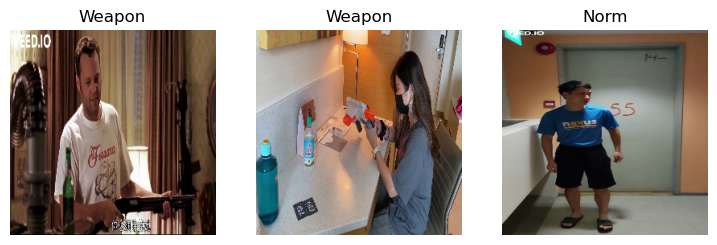

In [5]:
class_names = ['Norm', 'Weapon']

fig = plt.figure(figsize=(9, 12))
for image, label in train_ds.take(1):
  for i in range(3):
    print()
    plt.subplot(1, 3, i + 1)
    plt.imshow((image[i]).numpy().astype('int32'))
    plt.title(class_names[label[i].numpy()])
    plt.axis('off')

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (tf.keras.layers.Rescaling(1./127.5, offset=-1)(x), y))
val_ds = val_ds.map(lambda x, y: (tf.keras.layers.Rescaling(1./127.5, offset=-1)(x), y))

In [7]:
optimizer = tf.keras.optimizers.Adam()

entropy = tf.keras.losses.BinaryCrossentropy()

metric = tf.keras.metrics.BinaryAccuracy()

In [8]:
def DiffAugment(x, policy='', channels_first=False):
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    return x


def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + magnitude
    return x


def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x


def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x


AUGMENT_FNS = { 
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout]
}

In [9]:
def basic_block(x, filter, stride):
  input = x

  x = layers.Conv2D(filter, 3, stride, padding='same', kernel_initializer="he_normal")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filter, 3, 1, padding='same', kernel_initializer="he_normal")(x)
  x = layers.BatchNormalization()(x)
  
  if stride != 1:
    input = layers.Conv2D(filter, 1, 2, padding='same', kernel_initializer="he_normal")(input)
    input = layers.BatchNormalization()(input)

  x = layers.Add()([x, input])
  x = layers.ReLU()(x)

  return x

In [10]:
def resnet18():

  input = layers.Input((256, 256, 3))
  x = layers.ZeroPadding2D((3, 3))(input)
  x = layers.Conv2D(64, 7, 2, padding='same', kernel_initializer="he_normal")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.MaxPool2D(3, 2, padding='same')(x)

  num_blocks = [2, 2, 2, 2]
  filter = 64
  for i in range(len(num_blocks)):
    for j in range(num_blocks[i]):
      x = basic_block(x, filter, [2, 1][i == 0])
    filter *= 2

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(inputs = input, outputs = x, name = "ResNet18")
  return model


classifier = resnet18()
classifier.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 131, 131, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [11]:
class ResNet18(Model):

  def __init__(self, classifier, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.classifier = classifier
    self.weight = 0.1

  def compile(self, optimizer, entropy, metric, *args, **kwargs):
    super().compile(*args, **kwargs)

    self.optimizer = optimizer
    self.loss = entropy
    self.val_acc_metric = metric

  def train_step(self, data):

    images, labels = data
    

    with tf.GradientTape() as cls_tape:
    
      images = DiffAugment(images, policy='color,translation,cutout')

      prediction = self.classifier(images, training=True)

      losses = self.loss(labels, prediction)

    gradients_of_classifier = cls_tape.gradient(losses, self.classifier.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients_of_classifier, self.classifier.trainable_variables))
    
    return {'c_loss':  losses} 

  def test_step(self, data):

    real_images, real_labels = data

    prediction = self.classifier(real_images, training=False)

    val_loss = self.loss(real_labels, prediction)

    self.val_acc_metric.update_state(real_labels, prediction)

    return {'loss': val_loss, 'acc': self.val_acc_metric.result()}

In [13]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoints/resnet18.{epoch:03d}',
    save_weights_only=True
)

In [14]:
model = ResNet18(classifier)
model.compile(optimizer, entropy, metric)
hist = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=100,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
48/48 [==============================] - 97s 1s/step - c_loss: 0.7607 - val_loss: 13.4968 - val_acc: 0.0373
Epoch 2/100
48/48 [==============================] - 6s 131ms/step - c_loss: 0.6139 - val_loss: 0.9442 - val_acc: 0.9518
Epoch 3/100
48/48 [==============================] - 6s 132ms/step - c_loss: 0.5722 - val_loss: 0.6515 - val_acc: 0.5110
Epoch 4/100
48/48 [==============================] - 6s 125ms/step - c_loss: 0.5336 - val_loss: 0.8890 - val_acc: 0.5000
Epoch 5/100
48/48 [==============================] - 6s 130ms/step - c_loss: 0.5229 - val_loss: 0.8288 - val_acc: 0.7325
Epoch 6/100
48/48 [==============================] - 6s 131ms/step - c_loss: 0.4875 - val_loss: 0.3615 - val_acc: 0.6316
Epoch 7/100
48/48 [==============================] - 6s 132ms/step - c_loss: 0.4689 - val_loss: 0.5348 - val_acc: 0.7412
Epoch 8/100
48/48 [==============================] - 6s 135ms/step - c_loss: 0.4361 - val_loss: 0.6683 - val_acc: 0.4781
Epoch 9/100
48/48 [==============

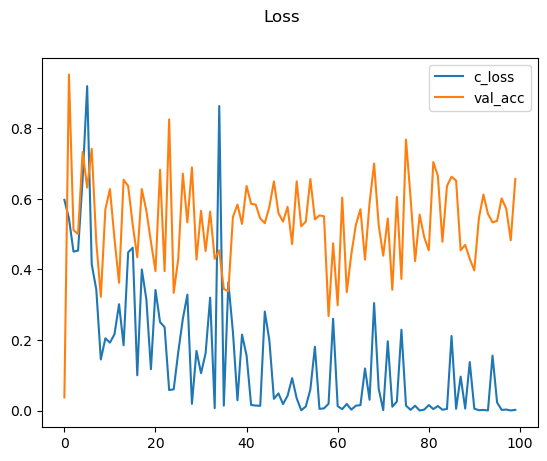

In [16]:
plt.suptitle('Loss')
plt.plot(hist.history['c_loss'], label='c_loss')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

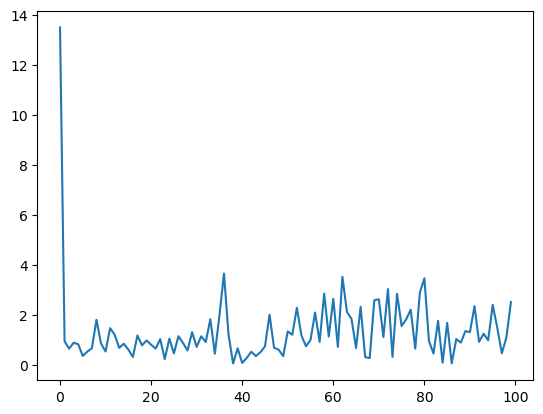

In [17]:
plt.plot(hist.history['val_loss'], label='val_loss')

In [19]:
model.evaluate(tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/weapondetection/Weapons',
    image_size=(256, 256), 
    batch_size=32,
    shuffle=True
).map(lambda x, y: (tf.keras.layers.Rescaling(1./127.5, offset=-1)(x), y)))

Found 8093 files belonging to 2 classes.
253/253 [==============================] - 29s 111ms/step - loss: 1.4944 - acc: 0.5872


[0.5870505571365356, 1.7867207527160645]